In [2]:
# %matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from scipy.stats import mannwhitneyu

from utils import change_markers_latex

In [3]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 12  # width in inches
fig_height = 9  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette
(nt_colors))

# Load data

In [4]:
def symbol_fun(x):
    if  x== 'p < 0.05 FDR corrected':
        symbols = 'hexagram' 
    elif x == 'p < 0.05 uncorrected':
        symbols = 'circle'
    else:
        symbols = 'circle-open'
            
    return symbols

In [5]:
df_markers = pd.read_csv('Data/all_markers.csv')

svm_mind = pd.read_csv('Data/univariate_roc_mind_segment.csv')


aucs_mind = svm_mind.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'}).assign(symbol = lambda df: df.significant.apply(symbol_fun))

svm_mw = pd.read_csv('Data/univariate_roc_mw_segment.csv')
aucs_mw = svm_mw.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'}).assign(symbol = lambda df: df.significant.apply(symbol_fun))
                     
                     
significant_mind = aucs_mind.query("significant != 'p > 0.05'").markers.to_list()
significant_mw = aucs_mw.query("significant != 'p > 0.05'").markers.to_list()


significant_markers = significant_mind + significant_mw

In [6]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .groupby(['mind2'], as_index = False).mean()
).melt(id_vars = ['mind2'], var_name = 'markers', value_name = 'val')

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['mind'], as_index =False).mean()
).melt(id_vars = ['mind'], var_name = 'markers', value_name = 'val')


In [ ]:
# markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
#        'p_e_4', 'p_e_8', 'k', 'b', 'b_n', 'g', 'g_n', 't', 't_n',
#        'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']

markers =  [r'$\delta$',r'$|\delta|$',r'$\theta$', r'$|\theta|$',r'$\alpha$', r'$|\alpha|$',r'$\beta$', r'$|\beta|$',r'$\gamma$', r'$|\gamma|$',
            r'$PE\gamma$',r'$PE\beta$',r'$PE\alpha$',r'$PE\theta$',
            r'$wSMI\gamma$',r'$wSMI\beta$',r'$wSMI\alpha$',r'$wSMI\theta$', 
            r'$K$',r'$SE$',r'$MSF$', r'$SEF90$', r'$SEF95$', 
            r'$CNV$', r'$P1$', r'$P3a$',r'$P3b$'
           ]

erps =['CNV', 'P1', 'P3a', 'P3b']
freqs = ['d','t','a', 'b','g']
freqs_n = ['d_n','t_n','a_n', 'b_n','g_n']
wsmi = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8',]
p_e = [ 'p_e_1', 'p_e_2','p_e_4', 'p_e_8',]

types_markers = [erps, freqs, freqs_n, wsmi, p_e]

In [ ]:
def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip("#")
    if len(hex_color) == 3:
        hex_color = hex_color * 2
    return int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)

# All markerspolar plots

In [ ]:
mw =aucs_mw
mind =aucs_mind

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=np.ones(len(mind['markers'])) * 0.5,
    theta=mind['markers'],
    name = 'Chance: AUC = 0.5',
    mode = 'lines',
    line = {'color':'grey', 'width': 2, 'dash': 'dash' },
))


fig.add_trace(go.Scatterpolar(
    r=mw.AUC,
    theta=mw['markers'],
    fill='toself',
    name='dMW vs sMW',
    mode = 'lines+markers',
    marker = {'color':lblue, 'size': 10},
    marker_symbol= mw.symbol.to_list()
))

fig.add_trace(go.Scatterpolar(
    r=mind.AUC,
    theta=mind['markers'],
    fill='toself',
    name='OT vs MW',
    mode = 'lines+markers',
    marker = {'color':pink, 'size': 10},
    marker_symbol= mind.symbol.to_list()
))



fig.update_layout(
    title="AUC for all markers",
#     legend_title="Classification",
    width=800,
    height=800,
    template = 'plotly_white',
    
  polar=dict(
    radialaxis=dict(
    title = 'AUC',
      visible=True,
        range = [0.35,0.66]
    ),
  ),
    
  showlegend=True
)

fig.show()
pio.write_json(fig, 'Figs/radar_auc_all.plotly')

# Significant polar plots

In [ ]:
mw =aucs_mw[aucs_mw['markers'].isin([i for i in significant_markers])]
mind =aucs_mind[aucs_mind['markers'].isin([i for i in significant_markers])]

fig = go.Figure()


fig.add_trace(go.Scatterpolar(
    r=np.ones(len(mind['markers'])) * 0.5,
    theta=mind['markers'],
    name = 'Chance: AUC = 0.5',
    mode = 'lines',
    line = {'color':'grey', 'width': 2, 'dash': 'dash' },
))

fig.add_trace(go.Scatterpolar(
    r=mw.AUC,
    theta=mw['markers'],
    fill='toself',
    name='dTUT vs sTUT', 
    marker = {'color':lblue, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(lblue), 0.2)}",
    marker_symbol= mw.symbol.to_list()
))

fig.add_trace(go.Scatterpolar(
    r=mind.AUC,
    theta=mind['markers'],
    fill='toself',
    name='OT vs TUT',
    marker = {'color':pink, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(pink), 0.2)}",
    marker_symbol= mind.symbol.to_list()
))


fig.update_layout(
    # title="All Off-task against all for Significant markers",
#     legend_title="Classification",
    width=800,
    height=800,
    # autosize = True, 
        template = 'plotly_white',
        font=dict(
        family="Times new roman",
        # size=25,
        color="black"
    ),
    polar=dict(
        radialaxis=dict(
            title = 'AUC',
            visible=True,
            range = [0.35,0.66], 
            tickangle = 35,
            tickfont = {"size": 10},
            titlefont =  {"size": 15},
        ),
        angularaxis = dict(
        tickfont = {"size": 40},
        )
  ),
    showlegend=True
)
fig.show()
pio.write_json(fig, 'Figs/radar_auc_significant.plotly')
fig.write_image("Figs/radar_auc_significant.pdf")
fig.write_image("Figs/radar_auc_significant.png")

NameError: name 'aucs_mw' is not defined

# Radar plots for all type of markers

# Average vs Flucutuations

In [10]:
mind_average =aucs_mind[aucs_mind['markers'].str.contains("mean")]
mw_average =aucs_mw[aucs_mw['markers'].str.contains("mean")]

mind_fluctuations =aucs_mind[aucs_mind['markers'].str.contains("std")]

mw_fluctuations =aucs_mw[aucs_mw['markers'].str.contains("std")]

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles = ['Average', 'Fluctuations'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}], [{"type": "histogram"}, {"type": "histogram"}]],
                       column_widths=[0.5, 0.5],
    row_heights=[0.8, 0.2],
                   vertical_spacing = 0.1)

fig.add_trace(go.Scatter(
    x=mw_average.AUC,
    y=mw_average['markers'],
    name='dMW vs sMW',
    legendgroup= 'group1',
    showlegend=True,
    mode = 'markers',
    marker = {'color':lblue, 'size': 10},
    marker_symbol= mw_average.symbol.to_list()
))
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_trace(go.Scatter(
    x=mind_average.AUC,
    y=mind_average['markers'],
    name='OT vs MW',
    legendgroup= 'group2',
    showlegend=True,
    mode = 'markers',
    marker = {'color':pink, 'size': 10},
    marker_symbol= mind_average.symbol.to_list()
))

fig.add_trace(go.Histogram(
    x=mw_average.AUC,histnorm='probability',
    marker = {'color':lblue},
    name='dMW vs sMW',
    legendgroup= 'group1',    showlegend=True,
),row = 2, col = 1)

fig.add_trace(go.Histogram(
    x=mind_average.AUC,histnorm='probability',
    marker = {'color':pink}, 
    name='OT vs MW',    legendgroup= 'group2',
    showlegend=True,
    autobinx = False,
),row = 2, col = 1)

fig.update_traces(opacity=0.75, row = 2, col=1)





fig.add_trace(go.Scatter(
    x=mw_fluctuations.AUC,
    y=mw_fluctuations['markers'],
    name='dMW vs sMW',
    legendgroup= 'group1',    showlegend=False,
    mode = 'markers',
    marker = {'color':lblue, 'size': 10},
    marker_symbol= mw_fluctuations.symbol.to_list()
),
    row = 1, col = 2)

fig.add_trace(go.Scatter(
    x=mind_fluctuations.AUC,
    y=mind_fluctuations['markers'],
    name='OT vs MW',    legendgroup= 'group2',
    showlegend=False,
    mode = 'markers',
    marker = {'color':pink, 'size': 10},
    marker_symbol= mind_fluctuations.symbol.to_list()
),
    row = 1, col = 2)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)

fig.add_trace(go.Histogram(
    x=mw_fluctuations.AUC,histnorm='probability',
    name='dMW vs sMW',
    legendgroup= 'group1',    showlegend=False,
    marker = {'color':lblue},
),row = 2, col = 2)

fig.add_trace(go.Histogram(
    x=mind_fluctuations.AUC,histnorm='probability',
    marker = {'color':pink}, 
    name='OT vs MW',    legendgroup= 'group2',
    showlegend=False,
    autobinx = False,
),row = 2, col = 2)

fig.update_traces(opacity=0.75, row = 2, col=2)
# Update xaxis properties
fig.update_xaxes(title_text="AUC", range=[.35, .66],row=1, col=1)
fig.update_xaxes(title_text="AUC", range=[.35,.66], row=1, col=2)
fig.update_xaxes(title_text="AUC", range=[.35, .66],row=2, col=2)
fig.update_xaxes(title_text="AUC", range=[.35, .66],row=2, col=1)



fig.update_layout(
#     title="AUC for all markers",
    legend_title="Classification",
    width=1200,
    height=800,    
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        },
    barmode='overlay',
  showlegend=True,
    template = 'plotly_white'
)

fig.show()
pio.write_json(fig, 'Figs/scatter_auc_all.plotly')

In [11]:
mind_average =aucs_mind[aucs_mind['markers'].str.contains("mean")]
mw_average =aucs_mw[aucs_mw['markers'].isin([i+'_mean' for i in markers])]

mind_fluctuations =aucs_mind[aucs_mind['markers'].str.contains("std")]
mw_fluctuations =aucs_mw[aucs_mw['markers'].isin([i+'_std' for i in markers])]

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles = ['Average', 'Fluctuations'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}], [{"type": "histogram"}, {"type": "histogram"}]],
                       column_widths=[0.5, 0.5],
    row_heights=[0.8, 0.2],
                   vertical_spacing = 0.1)


fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_trace(go.Scatter(
    x=mind_average.AUC,
    y=mind_average['markers'],
    name='OT vs MW',
    legendgroup= 'group2',
    showlegend=True,
    mode = 'markers',
    marker = {'color':pink, 'size': 10},
    marker_symbol= mind_average.symbol.to_list()
))


fig.add_trace(go.Histogram(
    x=mind_average.AUC,histnorm='probability',
    marker = {'color':pink}, 
    name='OT vs MW',    legendgroup= 'group2',
    showlegend=True,
    autobinx = False,
),row = 2, col = 1)

fig.update_traces(opacity=0.75, row = 2, col=1)





fig.add_trace(go.Scatter(
    x=mind_fluctuations.AUC,
    y=mind_fluctuations['markers'],
    name='OT vs MW',    legendgroup= 'group2',
    showlegend=False,
    mode = 'markers',
    marker = {'color':pink, 'size': 10},
    marker_symbol= mind_fluctuations.symbol.to_list()
),
    row = 1, col = 2)

fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)



fig.add_trace(go.Histogram(
    x=mind_fluctuations.AUC,histnorm='probability',
    marker = {'color':pink}, 
    name='OT vs MW',    legendgroup= 'group2',
    showlegend=False,
    autobinx = False,
),row = 2, col = 2)

fig.update_traces(opacity=0.75, row = 2, col=2)
# Update xaxis properties
fig.update_xaxes(title_text="AUC", range=[.35, .66],row=1, col=1)
fig.update_xaxes(title_text="AUC", range=[.35,.66], row=1, col=2)
fig.update_xaxes(title_text="AUC", range=[.35, .66],row=2, col=2)
fig.update_xaxes(title_text="AUC", range=[.35, .66],row=2, col=1)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 1)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 2)


fig.update_layout(
#     title="AUC for all markers",
    legend_title="Classification",
    width=1200,
    height=800,    
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        },
    barmode='overlay',
  showlegend=True,
    template = 'plotly_white'
)

fig.show()
pio.write_json(fig, 'Figs/scatter_average_fluctuations_otvsmw.plotly')

## Mirrored

In [37]:
mind_average =aucs_mind[aucs_mind['markers'].str.contains("mean")].assign(AUC_mirror = lambda df: np.where(df.AUC < 0.5, 
                                                                                                                         1 - df.AUC, df.AUC) )
mw_average =aucs_mw[aucs_mw['markers'].str.contains("mean")].assign(AUC_mirror = lambda df: np.where(df.AUC < 0.5, 
                                                                                                                        1 - df.AUC, df.AUC) )

mind_fluctuations =aucs_mind[aucs_mind['markers'].str.contains("std")].assign(AUC_mirror = lambda df: np.where(df.AUC < 0.5, 
                                                                                                                         1 - df.AUC, df.AUC) )
mw_fluctuations =aucs_mw[aucs_mw['markers'].str.contains("std")].assign(AUC_mirror = lambda df: np.where(df.AUC < 0.5, 
                                                                                                                         1 - df.AUC, df.AUC) )

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles = ['Average', 'Fluctuations'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}], [{"type": "histogram"}, {"type": "histogram"}]],
                       column_widths=[0.5, 0.5],
    row_heights=[0.8, 0.2],
                   vertical_spacing = 0.1)

fig.add_trace(go.Scatter(
    x=mw_average.AUC_mirror,
    y=mw_average['markers'],
    name='dTUT vs sTUT',
    legendgroup= 'group1',
    showlegend=True,
    mode = 'markers',
    marker = {'color':lblue, 'size': 10},
    marker_symbol= mw_average.symbol.to_list()
))
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_trace(go.Scatter(
    x=mind_average.AUC_mirror,
    y=mind_average['markers'],
    name='OT vs TUT',
    legendgroup= 'group2',
    showlegend=True,
    mode = 'markers',
    marker = {'color':pink, 'size': 10},
    marker_symbol= mind_average.symbol.to_list()
))

fig.add_trace(go.Histogram(
    x=mw_average.AUC_mirror,histnorm='probability',
    marker = {'color':lblue},
    name='dTUT vs sTUT',
    legendgroup= 'group1',    showlegend=True,
),row = 2, col = 1)

fig.add_trace(go.Histogram(
    x=mind_average.AUC_mirror,histnorm='probability',
    marker = {'color':pink}, 
    name='OT vs TUT',    legendgroup= 'group2',
    showlegend=True,
    autobinx = False,
),row = 2, col = 1)

fig.update_traces(opacity=0.75, row = 2, col=1)





fig.add_trace(go.Scatter(
    x=mw_fluctuations.AUC_mirror,
    y=mw_fluctuations['markers'],
    name='dTUT vs sTUT',
    legendgroup= 'group1',    showlegend=False,
    mode = 'markers',
    marker = {'color':lblue, 'size': 10},
    marker_symbol= mw_fluctuations.symbol.to_list()
),
    row = 1, col = 2)

fig.add_trace(go.Scatter(
    x=mind_fluctuations.AUC_mirror,
    y=mind_fluctuations['markers'],
    name='OT vs TUT',    legendgroup= 'group2',
    showlegend=False,
    mode = 'markers',
    marker = {'color':pink, 'size': 10},
    marker_symbol= mind_fluctuations.symbol.to_list()
),
    row = 1, col = 2)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)

fig.add_trace(go.Histogram(
    x=mw_fluctuations.AUC_mirror,histnorm='probability',
    name='dTUT vs sTUT',
    legendgroup= 'group1',    showlegend=False,
    marker = {'color':lblue},
),row = 2, col = 2)

fig.add_trace(go.Histogram(
    x=mind_fluctuations.AUC_mirror,histnorm='probability',
    marker = {'color':pink}, 
    name='OT vs TUT',    legendgroup= 'group2',
    showlegend=False,
    autobinx = False,
),row = 2, col = 2)

fig.update_traces(opacity=0.75, row = 2, col=2)
# Update xaxis properties
fig.update_xaxes(title_text="AUC", range=[.5, .66],row=1, col=1)
fig.update_xaxes(title_text="AUC", range=[.5,.66], row=1, col=2)
fig.update_xaxes(title_text="AUC", range=[.5, .66],row=2, col=2)
fig.update_xaxes(title_text="AUC", range=[.5, .66],row=2, col=1)



fig.update_layout(
#     title="AUC for all markers",
    legend_title="Classification",
    width=1200,
    height=800,    
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        },
    barmode='overlay',
  showlegend=True,
    template = 'plotly_white'
)

fig.show()
pio.write_json(fig, 'Figs/scatter_auc_all.plotly')
fig.write_image("Figs/scatter_auc_all.pdf")
fig.write_image("Figs//scatter_auc_all.png")

In [34]:
print('Statistics for Average AUC:', mannwhitneyu(mind_average.AUC_mirror, mw_average.AUC_mirror))
print('Statistics for Fluctuations AUC:', mannwhitneyu(mind_fluctuations.AUC_mirror, mw_fluctuations.AUC_mirror))

Statistics for Average AUC: MannwhitneyuResult(statistic=423.0, pvalue=0.3156685604494983)
Statistics for Fluctuations AUC: MannwhitneyuResult(statistic=524.0, pvalue=0.005945923869164794)


In [14]:
mind_fluctuations.AUC_mirror.median()

0.5364556305137519

In [15]:
mw_fluctuations.AUC_mirror.median()

0.5178321678321679

In [16]:
mind = mind_average.assign(marker = lambda df: df['markers'].str.replace('_{mean}', '')).merge(
mind_fluctuations.assign(marker = lambda df: df['markers'].str.replace('_{std}', '')), on = 'marker', how = 'inner'
)
mw = mw_average.assign(marker = lambda df: df['markers'].str.replace('_{mean}', '')).merge(
mw_fluctuations.assign(marker = lambda df: df['markers'].str.replace('_{std}', '')), on = 'marker', how = 'inner'
)

mind_regression = sm.OLS(mind.AUC_y, sm.add_constant(mind.AUC_x)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_y,sm.add_constant(mw.AUC_x)).fit().fittedvalues

fig = make_subplots(rows=1, cols=2, 
                    subplot_titles = ['OT vs MW', 'dMW vs sMW'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}]])

fig.add_trace(go.Scatter(
    x=mind.AUC_x,
    y=mind.AUC_y,
    text = mind.marker,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 5},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
))
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.AUC_x, y=mind_regression, mode='lines', line_color=pink), row = 1, col = 1)


fig.add_trace(go.Scatter(
    x=mw.AUC_x,
    y=mw.AUC_y,
    text = mw.marker,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 5},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =1, col = 2)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.AUC_x, y=mw_regression, mode='lines', line_color=lblue), row = 1, col = 2)


# Update xaxis properties
fig.update_xaxes(title_text="Average", range=[.35, .65],row=1, col=1)
fig.update_xaxes(title_text="Average", range=[.35,.65], row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Fluctuations", range=[.35, .65],row=1, col=1)
fig.update_yaxes(title_text="Fluctuations", range=[.35,.65], row=1, col=2)


fig.update_layout(
    width=1200,
    height=600,    
    template = "plotly_white",
    showlegend=False,

)

fig.show()
pio.write_json(fig, 'Figs/average_fluctuations_auc_all.plotly')

/var/folders/3p/z_m37csj5cs4hp5x2z1hsfrc0000gq/T/ipykernel_4462/3626589124.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/3p/z_m37csj5cs4hp5x2z1hsfrc0000gq/T/ipykernel_4462/3626589124.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/3p/z_m37csj5cs4hp5x2z1hsfrc0000gq/T/ipykernel_4462/3626589124.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/3p/z_m37csj5cs4hp5x2z1hsfrc0000gq/T/ipykernel_4462/3626589124.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.



# Multivariate vs Univariate

## Mind

In [17]:
univ_mind = pd.read_csv('Data/output_mind.csv').query("markers != 'Unnamed: 0_first'")
multi_mind = pd.read_csv('Data/multivariate_forest_mind_segment.csv').assign(markers = 'whole_model')
feat_imp_mind = pd.read_csv('Data/feat_import_multivariate_mind.csv')


In [18]:



fig1 = px.box(univ_mind, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange, lblue])


fig2 = px.box(multi_mind, y="markers", x="auc", template = "plotly_white")


fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig3.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis = {'title': 'MW>OT                          MW<OT'},
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }, 
    template = 'plotly_white'
)


fig3.show()
# pio.write_json(fig, 'Figs/univariate_svc_mw_segment.plotly')


## MW

In [19]:
univ_mw = pd.read_csv('Data/output_mw.csv').query("markers != 'Unnamed: 0_first'")
multi_mw = pd.read_csv('Data/multivariate_forest_mw_segment.csv').assign(markers = 'whole_model')
feat_imp_mw = pd.read_csv('Data/feat_import_multivariate_mw.csv')


In [20]:



fig1 = px.box(univ_mw, y="markers", x="AUC", color="significant", template = "plotly_white", color_discrete_sequence = [green, orange, lblue])


fig2 = px.box(multi_mw, y="markers", x="auc", template = "plotly_white")


fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig3.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis = {'title': 'sMW>dMW                         sMW<dMW'},
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        }, 
    template = 'plotly_white'
)


fig3.show()
# pio.write_json(fig, 'Figs/univariate_svc_mw_segment.plotly')


# Comparin UNIVARIATES

In [21]:
#### Mind ####
univ_extra_mind = pd.read_csv('Data/output_mind.csv').query("markers != 'Unnamed: 0_first'").groupby('markers',as_index =True).mean().reset_index()
univ_extra_mind = change_markers_latex(univ_extra_mind, 'markers')
univ_roc_mind = pd.read_csv('Data/univariate_roc_mind_segment.csv').assign(AUC_mirror = lambda df: np.where(df.AUC < 0.5, 
                                                                                        1 - df.AUC, df.AUC) )
feat_imp_mind = pd.read_csv('Data/feat_import_multivariate_mind.csv')

#### MW ####

univ_extra_mw = pd.read_csv('Data/output_mw.csv').query("markers != 'Unnamed: 0_first'").groupby('markers',as_index =True).mean().reset_index()
univ_extra_mw = change_markers_latex(univ_extra_mw, 'markers')

univ_roc_mw = pd.read_csv('Data/univariate_roc_mw_segment.csv').assign(AUC_mirror = lambda df: np.where(df.AUC < 0.5, 
                                                                                        1 - df.AUC, df.AUC) )

feat_imp_mw = pd.read_csv('Data/feat_import_multivariate_mw.csv')

In [22]:
mind = univ_extra_mind.merge(univ_roc_mind, on = 'markers', how = 'inner', suffixes = ('_extra', '_roc')).merge(feat_imp_mind, left_on = 'markers', right_on = 'features',  how = 'inner', suffixes = ('', '_fi'))

mw = univ_extra_mw.merge(univ_roc_mw, on = 'markers', how = 'inner', suffixes = ('_extra', '_roc')).merge(feat_imp_mind, left_on = 'markers', right_on = 'features',  how = 'inner', suffixes = ('', '_fi'))



## ROC vs Extra trees

In [23]:
mind_regression = sm.OLS(mind.AUC_roc, sm.add_constant(mind.AUC_extra)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_roc,sm.add_constant(mw.AUC_extra)).fit().fittedvalues

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles = ['OT vs MW', 'dMW vs sMW'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}], [{"type": "scatter"}, {"type": "scatter"}]],
                                           column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
                   vertical_spacing = 0.1)

fig.add_trace(go.Scatter(
    x=mind.AUC_extra,
    y=mind.AUC_roc,
    text = mind.markers,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
),row = 1, col = 1)
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.AUC_extra, y=mind_regression, mode='lines', line_color=pink), row = 1, col = 1)


fig.add_trace(go.Scatter(
    x=mw.AUC_extra,
    y=mw.AUC_roc,
    text = mw.markers,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =1, col = 2)

fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.AUC_extra, y=mw_regression, mode='lines', line_color=lblue), row = 1, col = 2)

# # Update xaxis properties
fig.update_xaxes(title_text="Univariate Extra-Trees",row=1, col=1)
fig.update_xaxes(title_text="Univariate Extra-Trees",row=1, col=2)

# # Update yaxis properties
fig.update_yaxes(title_text="Univariate ROC curve", row=1, col=1)
fig.update_yaxes(title_text="Univariate ROC curve", row=1, col=2)

##################
#### Mirrored ####
##################

mind_regression = sm.OLS(mind.AUC_mirror, sm.add_constant(mind.AUC_extra)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_mirror,sm.add_constant(mw.AUC_extra)).fit().fittedvalues


fig.add_trace(go.Scatter(
    x=mind.AUC_extra,
    y=mind.AUC_mirror,
    text = mind.markers,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
),row = 2, col = 1)
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.AUC_extra, y=mind_regression, mode='lines', line_color=pink), row = 2, col = 1)


fig.add_trace(go.Scatter(
    x=mw.AUC_extra,
    y=mw.AUC_mirror,
    text = mw.markers,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =2, col = 2)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.AUC_extra, y=mw_regression, mode='lines', line_color=lblue), row = 2, col = 2)


# # Update xaxis properties
fig.update_xaxes(title_text="Univariate Extra-Trees",row=2, col=1)
fig.update_xaxes(title_text="Univariate Extra-Trees",row=2, col=2)

# # Update yaxis properties
fig.update_yaxes(title_text="Mirrored ROC curve", row=2, col=1)
fig.update_yaxes(title_text="Mirrored ROC curve", row=2, col=2)



fig.update_layout(
    width=1200,
    height=1200,    
    template = "plotly_white",
    showlegend=False,

)

fig.show()
pio.write_json(fig, 'Figs/univariate_roc_extratrees.plotly')
fig.write_image('Figs/univariate_roc_extratrees.png')
fig.write_image("Figs//univariate_roc_extratrees.pdf")

## vs Feat importance

In [24]:
mind_regression = sm.OLS(mind.AUC_roc, sm.add_constant(mind.mean_importance)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_roc,sm.add_constant(mw.mean_importance)).fit().fittedvalues

fig = make_subplots(rows=2, cols=2, 
                    subplot_titles = ['OT vs MW', 'dMW vs sMW'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}], [{"type": "scatter"}, {"type": "scatter"}]],
                                           column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
                   vertical_spacing = 0.1)

fig.add_trace(go.Scatter(
    x=mind.mean_importance,
    y=mind.AUC_roc,
    text = mind.markers,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
),row = 1, col = 1)
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.mean_importance, y=mind_regression, mode='lines', line_color=pink), row = 1, col = 1)


fig.add_trace(go.Scatter(
    x=mw.mean_importance,
    y=mw.AUC_roc,
    text = mw.markers,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =1, col = 2)

# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.mean_importance, y=mw_regression, mode='lines', line_color=lblue), row = 1, col = 2)

# # Update xaxis properties
fig.update_xaxes(title_text="Average Feature importance MVPA",row=1, col=1)
fig.update_xaxes(title_text="Average Feature importance MVPA",row=1, col=2)

# # Update yaxis properties
fig.update_yaxes(title_text="ROC curve", row=1, col=1)
fig.update_yaxes(title_text="ROC curve", row=1, col=2)

##################
#### Mirrored ####
##################

mind_regression = sm.OLS(mind.AUC_mirror, sm.add_constant(mind.mean_importance)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_mirror,sm.add_constant(mw.mean_importance)).fit().fittedvalues


fig.add_trace(go.Scatter(
    x=mind.mean_importance,
    y=mind.AUC_mirror,
    text = mind.markers,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
),row = 2, col = 1)
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.mean_importance, y=mind_regression, mode='lines', line_color=pink), row = 2, col = 1)


fig.add_trace(go.Scatter(
    x=mw.mean_importance,
    y=mw.AUC_mirror,
    text = mw.markers,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =2, col = 2)
# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.mean_importance, y=mw_regression, mode='lines', line_color=lblue), row = 2, col = 2)


# # Update xaxis properties
fig.update_xaxes(title_text="Average Feature importance MVPA",row=2, col=1)
fig.update_xaxes(title_text="Average Feature importance MVPA",row=2, col=2)

# # Update yaxis properties
fig.update_yaxes(title_text="Mirrored ROC curve", row=2, col=1)
fig.update_yaxes(title_text="Mirrored ROC curve", row=2, col=2)



fig.update_layout(
    width=1200,
    height=1200,    
    template = "plotly_white",
    showlegend=False,

)

fig.show()
# pio.write_json(fig, 'Figs/univariate_roc_extratrees.plotly')
fig.write_image('Figs/univariate_roc_featimp.png', width=1200, height=1200)
fig.write_image("Figs//univariate_roc_featimp.pdf")

## Mirrored Ones

In [25]:
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles = ['OT vs MW', 'dMW vs sMW'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}], [{"type": "scatter"}, {"type": "scatter"}]],
                                           column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
                   vertical_spacing = 0.1)

##################
#### Mirrored Extra trees ####
##################
mind_regression = sm.OLS(mind.AUC_mirror, sm.add_constant(mind.AUC_extra)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_mirror,sm.add_constant(mw.AUC_extra)).fit().fittedvalues


fig.add_trace(go.Scatter(
    x=mind.AUC_extra,
    y=mind.AUC_mirror,
    text = mind.markers,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
),row = 1, col = 1)
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.AUC_extra, y=mind_regression, mode='lines', line_color=pink), row = 1, col = 1)


fig.add_trace(go.Scatter(
    x=mw.AUC_extra,
    y=mw.AUC_mirror,
    text = mw.markers,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =1, col = 2)
fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.AUC_extra, y=mw_regression, mode='lines', line_color=lblue), row = 1, col = 2)


# # Update xaxis properties
fig.update_xaxes(title_text="Univariate Extra-Trees",row=1, col=1)
fig.update_xaxes(title_text="Univariate Extra-Trees",row=1, col=2)

# # Update yaxis properties
fig.update_yaxes(title_text="Mirrored ROC curve", row=1, col=1)
fig.update_yaxes(title_text="Mirrored ROC curve", row=1, col=2)



##################
#### Mirrored ####
##################

mind_regression = sm.OLS(mind.AUC_mirror, sm.add_constant(mind.mean_importance)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_mirror,sm.add_constant(mw.mean_importance)).fit().fittedvalues


fig.add_trace(go.Scatter(
    x=mind.mean_importance,
    y=mind.AUC_mirror,
    text = mind.markers,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
),row = 2, col = 1)
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.mean_importance, y=mind_regression, mode='lines', line_color=pink), row = 2, col = 1)


fig.add_trace(go.Scatter(
    x=mw.mean_importance,
    y=mw.AUC_mirror,
    text = mw.markers,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =2, col = 2)
# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 2, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.mean_importance, y=mw_regression, mode='lines', line_color=lblue), row = 2, col = 2)


# # Update xaxis properties
fig.update_xaxes(title_text="Average Feature importance MVPA",row=2, col=1)
fig.update_xaxes(title_text="Average Feature importance MVPA",row=2, col=2)

# # Update yaxis properties
fig.update_yaxes(title_text="Mirrored ROC curve", row=2, col=1)
fig.update_yaxes(title_text="Mirrored ROC curve", row=2, col=2)



fig.update_layout(
    width=1200,
    height=1200,    
    template = "plotly_white",
    showlegend=False,

)

fig.show()
# pio.write_json(fig, 'Figs/univariate_roc_extratrees.plotly')
fig.write_image('Figs/univariate_mirrored.png', width=1200, height=1200)
fig.write_image("Figs//univariate_mirrored.pdf")

## Feat importance vs Extra Trees

In [26]:
mind_regression = sm.OLS(mind.AUC_extra, sm.add_constant(mind.mean_importance)).fit().fittedvalues
mw_regression = sm.OLS(mw.AUC_extra,sm.add_constant(mw.mean_importance)).fit().fittedvalues

fig = make_subplots(rows=1, cols=2, 
                    subplot_titles = ['OT vs MW', 'dMW vs sMW'],
                    specs=[[{"type": "scatter"}, {"type": "scatter"}],],)

fig.add_trace(go.Scatter(
    x=mind.mean_importance,
    y=mind.AUC_extra,
    text = mind.markers,
    mode = 'markers+text',
    marker = {'color':pink, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
),row = 1, col = 1)
# fig.add_trace(px.scatter(mind, x = 'AUC_x', y = 'AUC_y', trendline= 'ols', text = 'marker'), row = 1, col = 1)

# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 1)

fig.add_trace(go.Scatter(name='line of best fit', x=mind.mean_importance, y=mind_regression, mode='lines', line_color=pink), row = 1, col = 1)


fig.add_trace(go.Scatter(
    x=mw.mean_importance,
    y=mw.AUC_extra,
    text = mw.markers,
    mode = 'markers+text',
    marker = {'color':lblue, 'size': 10},
#     marker_symbol= symbol_fun(mind, significant_mw)
    
), row =1, col = 2)

# fig.add_vline(x=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_hline(y=0.5, line_width=1, line_dash="dash", line_color="grey", row = 1, col = 2)
fig.add_trace(go.Scatter(name='line of best fit', x=mw.mean_importance, y=mw_regression, mode='lines', line_color=lblue), row = 1, col = 2)

# # Update xaxis properties
fig.update_xaxes(title_text="Average Feature importance MVPA",row=1, col=1)
fig.update_xaxes(title_text="Average Feature importance MVPA",row=1, col=2)

# # Update yaxis properties
fig.update_yaxes(title_text="Univariate Extra-Trees", row=1, col=1)
fig.update_yaxes(title_text="Univariate Extra-Trees", row=1, col=2)



fig.update_layout(
    width=1200,
    height=600,    
    template = "plotly_white",
    showlegend=False,

)

fig.show()
# pio.write_json(fig, 'Figs/average_fluctuations_auc_all.plotly')

# Multivariates together

In [27]:
mind_multi = pd.read_csv('Data/multivariate_forest_mind_segment.csv').assign(contrast = 'OT vs MW')
mw_multi = pd.read_csv('Data/multivariate_forest_mw_segment.csv').assign(contrast = 'dMW vs sMW')

multivariates = mind_multi.append(mw_multi)


In [28]:
fig = go.Figure()

fig.add_trace(go.Violin(y=multivariates['contrast'][multivariates['contrast'] == 'dMW vs sMW'],
                            x=multivariates['auc'][multivariates['contrast'] == 'dMW vs sMW'],
                            points='all',
                            pointpos=0,
                            box_visible=True,
                            meanline_visible=True, 
                            line_color = lblue,
                            orientation = 'h',
                            name = 'dMW vs sMW'
                            
                            ))

fig.add_trace(go.Violin(y=multivariates['contrast'][multivariates['contrast'] == 'OT vs MW'],
                            x=multivariates['auc'][multivariates['contrast'] == 'OT vs MW'],
                            points='all',
                            pointpos=0,
                            box_visible=True,
                            meanline_visible=True, 
                            line_color = pink,
                            orientation = 'h',
                            name = 'OT vs MW'
                            ))


fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")


fig.update_layout(
#     title = f'Mean AUC = {df_forest_mw.auc.mean()}',
    template = 'plotly_white',
    autosize=False,
    width=800,
    height=500,
    font=dict(
        family="Times new roman, monospace",
        color="black"
    ),
    yaxis = {'title': '',
            'showticklabels': True,
            'tickmode': 'linear',
            'tickfont' : {"size": 20},
            'titlefont' :  {"size": 15},},
    xaxis ={'title': 'AUC',
            'range':[0.4, 0.85],
            'tickfont' : {"size": 20},
            'titlefont' :  {"size": 25},
        },
    showlegend = False,
)
fig.show()
pio.write_json(fig, 'Figs/multivariates.plotly')
fig.write_image('Figs/multivariates.pdf')


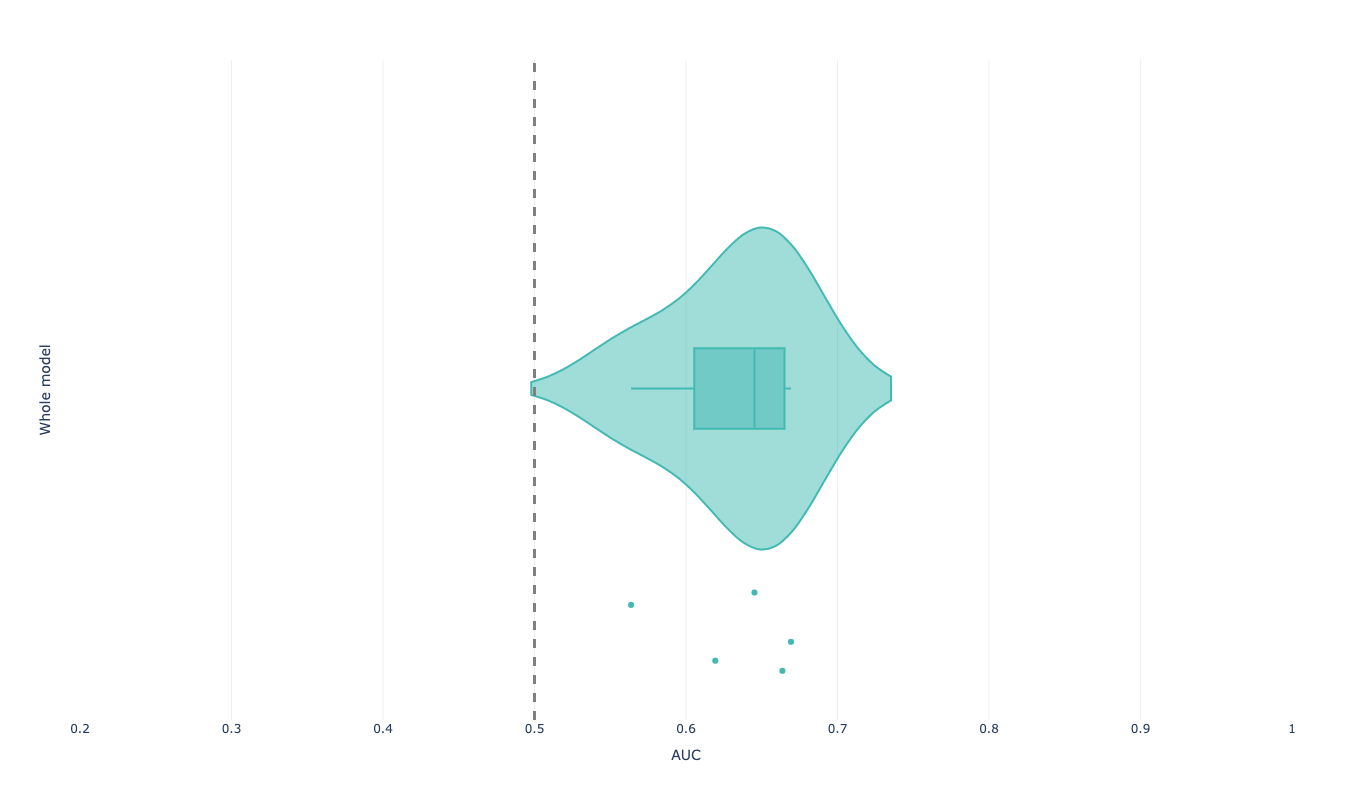

In [ ]:
fig =px.violin(df_forest_mw, x = 'auc', box = True, points = 'all',template = "plotly_white", color_discrete_sequence = [lblue], labels = {'auc': 'AUC'})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
#     title = f'Mean AUC = {df_forest_mw.auc.mean()}',
    autosize=False,
    width=800,
    height=800,
    yaxis = {'title': 'Whole model',
            'showticklabels': True,
            'tickmode': 'linear',},
    xaxis ={
             'range':[0.2, 1]
        }
)
fig.show()

# PCA

In [ ]:
variance = lambda x: np.std(x)/np.mean(x)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers.query("probe == 'PC'")
    .groupby(["segment", "participant"], as_index=False)
    .agg(agg_dict)
    #     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(mind2=lambda df: np.where(df.mind == "on-task", "on-task", "mw"))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind = df_mind.rename(
    columns={
        "participant_first": "participant",
        "probe_first": "probe",
        "mind_first": "mind",
        "segment_first": "segment",
        "mind2_": "mind2",
    }
).drop(["participant", "probe", "mind", "segment", ], axis=1)


# mind_components = pd.DataFrame([])
# X_pca = pd.DataFrame()


y, lbl = pd.factorize(df_mind['mind2'])
X = df_mind[df_mind.drop(['mind2', 'Unnamed: 0_first'], axis=1).columns].astype("float32").values
X = StandardScaler().fit_transform(X)


pca = PCA(n_components = 3)
pca.fit(X,y)
X_pca = pd.DataFrame(pca.transform(X) )

display(
pca.explained_variance_
)
# mind_components = pd.DataFrame(pca.components_.T, index = [x for marker in markers for x in (marker + '_mean', marker + '_std')]).reset_index()
# mind_components['mind'] = y

X_pca['mind'] = df_mind['mind2']
# X_pca= X_pca.append(_x_pca)

# mind_components = mind_components.append(df_)
    

array([11.555441,  6.408113,  3.657301], dtype=float32)

In [ ]:
agg_dict = {k:['mean','std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_mw.columns = df_mw.columns.map("_".join)

df_mw  = (df_mw
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'probe', 'segment'], axis = 1) 
           )


y, lbl = pd.factorize(df_mw['mind'])
X = df_mw[df_mw.drop(['mind', 'Unnamed: 0_first'], axis=1).columns].astype("float32").values
X = StandardScaler().fit_transform(X)


pca = PCA(n_components = 3)
pca.fit(X,y)
X_pca_mw = pd.DataFrame(pca.transform(X) )

display(
pca.explained_variance_
)
# mind_components = pd.DataFrame(pca.components_.T, index = [x for marker in markers for x in (marker + '_mean', marker + '_std')]).reset_index()
# mind_components['mind'] = y

X_pca_mw['mind'] = df_mw['mind']
# X_pca= X_pca.append(_x_pca)

# mind_components = mind_components.append(df_)
    


array([11.2843075,  5.670618 ,  3.1923199], dtype=float32)

In [ ]:
fig = px.scatter(mind_components, x=0, y=1, color="mind", text = 'index')
fig.show()


NameError: name 'mind_components' is not defined

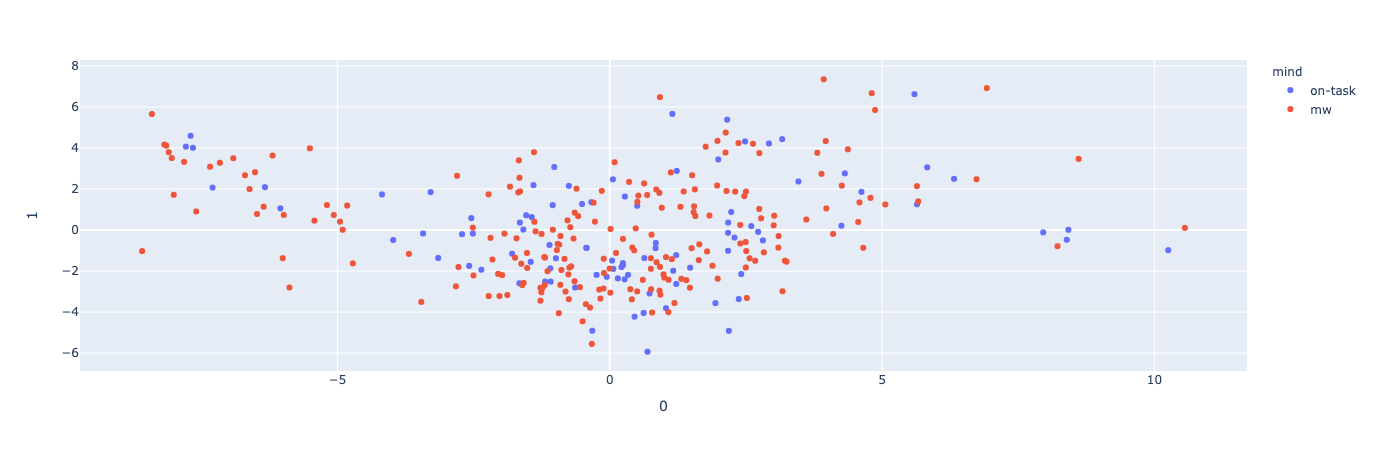

In [ ]:
fig = px.scatter(X_pca, x=0, y=1, color="mind")
# fig = px.scatter_3d(X_pca, x=0, y=1,z=2, color="mind")
fig.show()

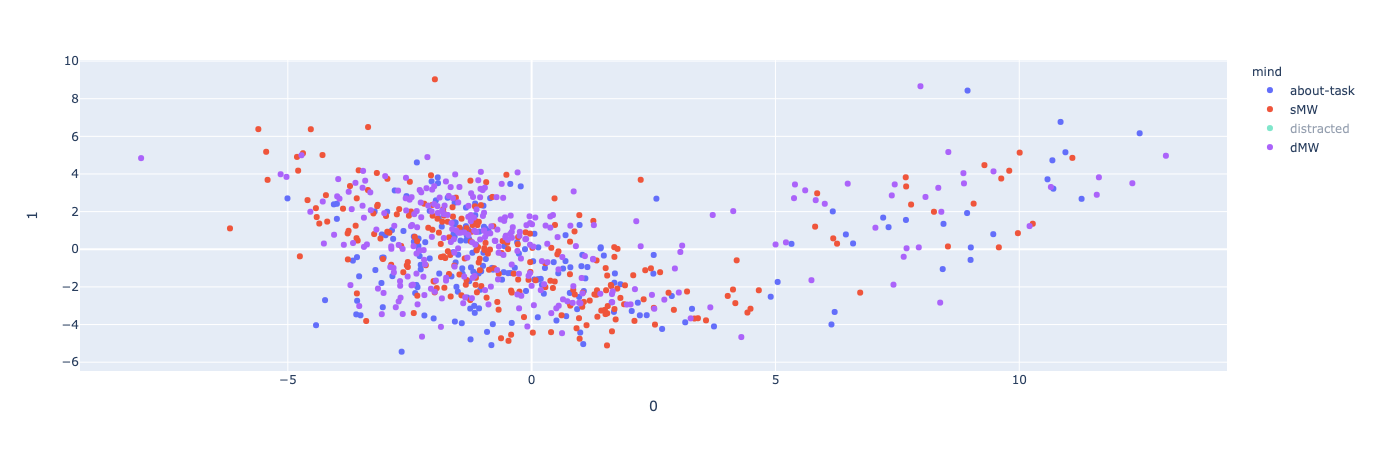

In [ ]:
fig = px.scatter(X_pca_mw, x=0, y=1, color="mind")
# fig = px.scatter_3d(X_pca_mw, x=0, y=1,z=2, color="mind")
fig.show()